# **Group Work Project 1 of Deep Learning**

|Student Group | 6888 |
|:---|:---|
|Team member A | Ebenezer Yeboah |
|Team member B | Jatin Rai |


---

In [53]:
!pip install pyts

In [54]:
# load libraries

import math
from scipy.optimize import brute, fmin
from scipy.integrate import quad
import yfinance as yf
import pandas_datareader as pdr  # Access FRED
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pyts.image import GramianAngularField
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


# **STEP 1**

## 1.a

In [55]:

equity = 'NVDA'
data = yf.download(equity, start="2018-01-01", end="2023-01-01")
prices = data['Close']
prices = prices.dropna()
prices

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02     4.98375
2018-01-03     5.31175
2018-01-04     5.33975
2018-01-05     5.38500
2018-01-08     5.55000
                ...   
2022-12-23    15.20600
2022-12-27    14.12100
2022-12-28    14.03600
2022-12-29    14.60300
2022-12-30    14.61400
Name: Close, Length: 1259, dtype: float64

In [56]:
mean_price = prices.mean()
std_dev = prices.std()
skewness = prices.skew()
kurtosis = prices.kurtosis()

In [57]:
print(f"NVIDIA Mean Price: {mean_price}")
print(f"NVIDIA Standard Deviation: {std_dev}")
print(f"NVIDIA Skewness: {skewness}")
print(f"NVIDIA Kurtosis: {kurtosis}")

NVIDIA Mean Price: 11.628921757054954
NVIDIA Standard Deviation: 7.290270256745984
NVIDIA Skewness: 0.8477622855545613
NVIDIA Kurtosis: -0.14793621618754393


In [58]:
adf_test = adfuller(prices)
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-Value: {adf_test[1]}")

ADF Statistic: -1.189822058869551
P-Value: 0.6779586092964145


In [59]:
pd.plotting.autocorrelation_plot(prices)
plt.title(f"Autocorrelation of {equity} Closing Prices")
plt.show()

## 1.b

In [60]:
#Transformed
log_prices = np.log(prices)
log_diff = log_prices.diff().dropna()

In [61]:
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(prices, color='blue')
plt.title(f"{equity} Original Closing Prices")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(log_diff, color='orange')
plt.title(f"{equity} Log-Transformed and Differenced Closing Prices")
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
adf_test = adfuller(log_diff)
print(f"ADF Statistic (Transformed): {adf_test[0]}")
print(f"P-Value (Transformed): {adf_test[1]}")

ADF Statistic (Transformed): -11.584494696994538
P-Value (Transformed): 2.889453108158755e-21


In [63]:
mean_log_diff = log_diff.mean()
std_log_diff = log_diff.std()
skewness_log_diff = log_diff.skew()
kurtosis_log_diff = log_diff.kurtosis()

In [64]:
print(f"Mean of Transformed Series: {mean_log_diff}")
print(f"Standard Deviation of Transformed Series: {std_log_diff}")
print(f"Skewness of Transformed Series: {skewness_log_diff}")
print(f"Kurtosis of Transformed Series: {kurtosis_log_diff}")

Mean of Transformed Series: 0.0008551648667504726
Standard Deviation of Transformed Series: 0.03285949228530568
Skewness of Transformed Series: -0.4854047419868807
Kurtosis of Transformed Series: 3.7369815436293443


In [65]:
pd.plotting.autocorrelation_plot(log_diff)
plt.title(f"Autocorrelation of Transformed {equity} Closing Prices")
plt.show()

## 1.c

In [66]:
def fractional_difference(series, d, threshold=1e-5):
    weights = [1.0]
    for k in range(1, len(series)):
        weight = -weights[-1] * (d - k + 1) / k
        if abs(weight) < threshold:
            break
        weights.append(weight)
    weights = np.array(weights[::-1]).reshape(-1, 1)

    diff_series = np.empty(len(series))
    for i in range(len(series)):
        if i < len(weights):
            diff_series[i] = np.dot(weights[-i-1:].T, series[:i+1])
        else:
            diff_series[i] = np.dot(weights.T, series[i-len(weights)+1:i+1])
    return pd.Series(diff_series, index=series.index)

In [67]:
#fractional differencing with d=0.5
d = 0.5
prices_frac_diff = fractional_difference(prices, d)

adf_result = adfuller(prices_frac_diff.dropna())

<ipython-input-66-0f6bd05d7905>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff_series[i] = np.dot(weights[-i-1:].T, series[:i+1])
<ipython-input-66-0f6bd05d7905>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff_series[i] = np.dot(weights.T, series[i-len(weights)+1:i+1])


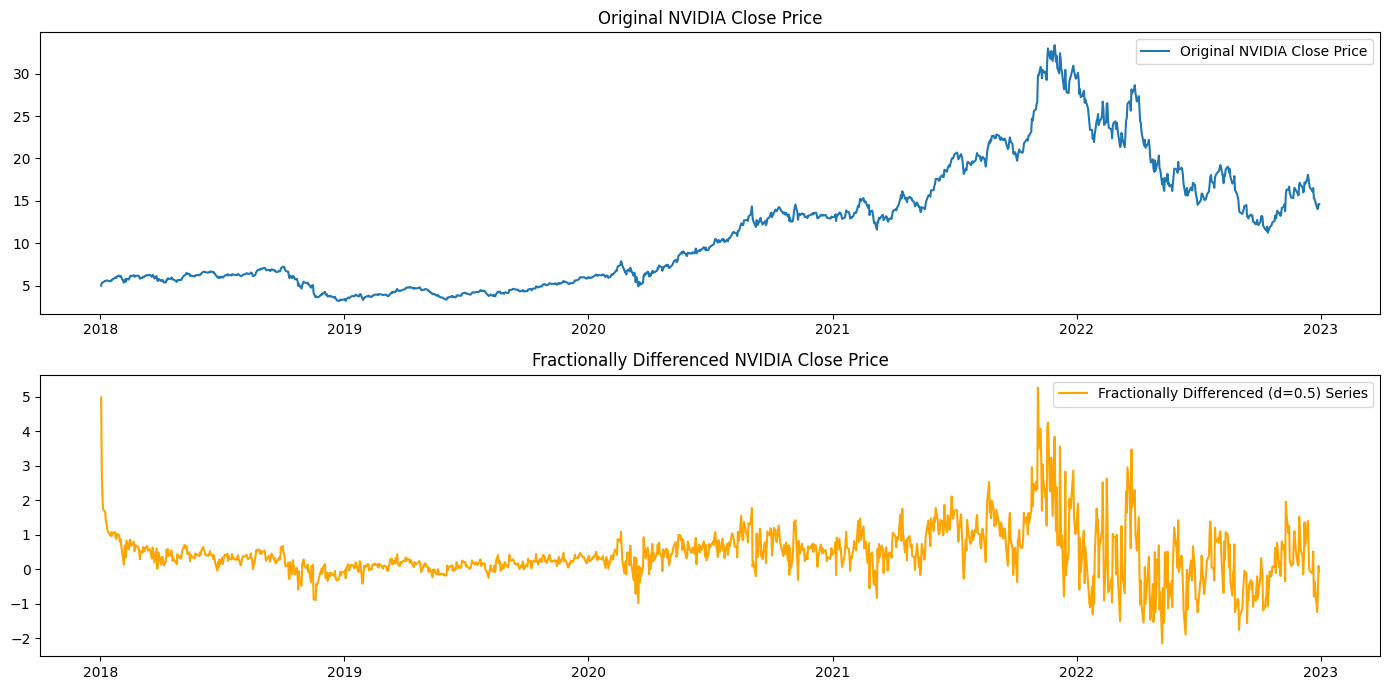

In [68]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(prices, label='Original NVIDIA Close Price')
plt.title('Original NVIDIA Close Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(prices_frac_diff, label='Fractionally Differenced (d=0.5) Series', color='orange')
plt.title('Fractionally Differenced NVIDIA Close Price')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
adf_statistic = adf_result[0]
p_value = adf_result[1]
summary_stats = prices_frac_diff.describe()

print(f"ADF Statistic: {adf_statistic}")
print(f"P-value: {p_value}")
print("\nSummary Statistics of Fractionally Differenced Series:")
print(summary_stats)

ADF Statistic: -4.412622453639931
P-value: 0.00028193123023862745

Summary Statistics of Fractionally Differenced Series:
count    1259.000000
mean        0.444649
std         0.740724
min        -2.151768
25%         0.084664
50%         0.352213
75%         0.736188
max         5.270633
dtype: float64


In [70]:
mean_log_diff = prices_frac_diff.mean()
std_log_diff = prices_frac_diff.std()
skewness_log_diff = prices_frac_diff.skew()
kurtosis_log_diff = prices_frac_diff.kurtosis()

In [71]:
print(f"\nMean of Transformed Series: {mean_log_diff}")
print(f"Standard Deviation of Transformed Series: {std_log_diff}")
print(f"Skewness of Transformed Series: {skewness_log_diff}")
print(f"Kurtosis of Transformed Series: {kurtosis_log_diff}")


Mean of Transformed Series: 0.44464932126837226
Standard Deviation of Transformed Series: 0.7407240835524618
Skewness of Transformed Series: 1.1614692906701285
Kurtosis of Transformed Series: 5.544937025898869


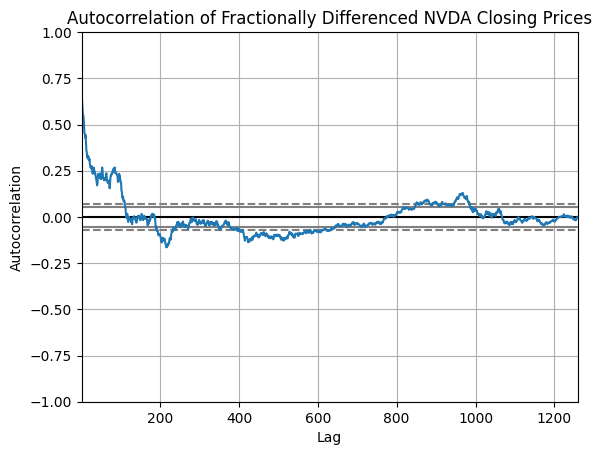

In [72]:
pd.plotting.autocorrelation_plot(prices_frac_diff)
plt.title(f'Autocorrelation of Fractionally Differenced {equity} Closing Prices')
plt.show()

## 1.d

In the first representation which has to do with the original form of the times series, the price of NVIDIA showed an upward trend which explains that the stock price has been increasing over time. With the second representation which has to do deal with the differencing of the stationary times series, the statistical properties remain the same over time which explains the stationarity here but vital information is lost which may affect the analysis of long term trends. The third representation, which is the fractional differencing, aims to achieve stationarity, that is the statistical properties such as the mean and variance being constant overtime and retain much of the original information which will be necessary to make relevant decisions over time. This explains the variations in the graphical representation of the three.

# **STEP 2**

## 2.a

In [73]:
lags = 5
X = pd.concat([prices.shift(i) for i in range(1, lags + 1)], axis=1).dropna()
y = prices.iloc[lags:]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 202.9341 - val_loss: 178.6966
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 175.9425 - val_loss: 153.7057
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 140.5147 - val_loss: 111.3548
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 95.5490 - val_loss: 57.9541
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 44.4507 - val_loss: 25.9541
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.7894 - val_loss: 20.0947
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.2587 - val_loss: 17.4765
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 15.1872 - val_loss: 14.3811
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 12.7156 - val_loss: 11.1205
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6215 - val_loss: 8.3082
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1409 - val_loss: 5.9738
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms

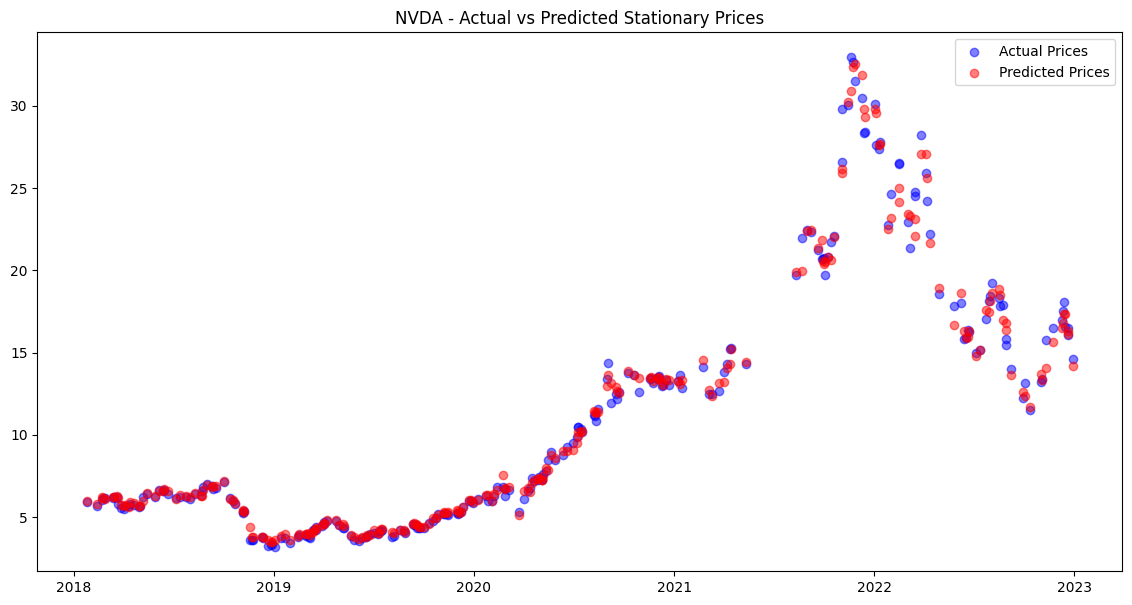

In [77]:
plt.figure(figsize=(14,7))
plt.scatter(y_test.index, y_test, label='Actual Prices', c='blue', alpha=0.5)
plt.scatter(y_test.index, y_pred, label='Predicted Prices', c='red', alpha=0.5)
plt.legend()
plt.title(f'{equity} - Actual vs Predicted Stationary Prices')
plt.show()

## 2.b

In [78]:
#Stationary_time_series
stationary_series = log_diff.dropna()

lags = 5
X = pd.concat([stationary_series.shift(i) for i in range(1, lags + 1)], axis=1).dropna()
y = stationary_series.iloc[lags:]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0315 - val_loss: 0.0066
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val

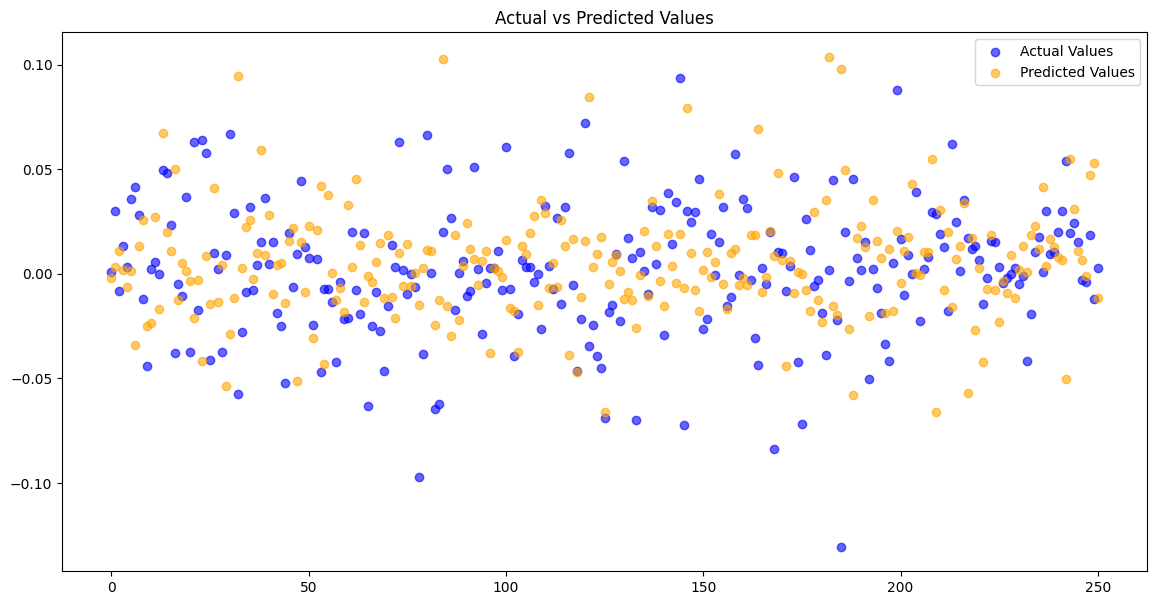

In [82]:
y_pred = y_pred.flatten()

min_len = min(len(y_test), len(y_pred))
y_test = y_test[:min_len]
y_pred = y_pred[:min_len]

plt.figure(figsize=(14,7))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', alpha=0.6, color='blue')
plt.scatter(range(len(y_test)), y_pred, label='Predicted Values', alpha=0.6, color='orange')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

## 2.d

The MSE which provides accuracy on the prediction gives us relevant analysis that the stationary times series has a higher accuracy than the normal times series and yes it is usually expected as the stationary times series contains trained data.
If in the attempt to remove noise using the stationary method coincidentally removes relevant data that it sees as noise, it may affect its prediction error and therefore making the normal times series better.


# **STEP 3**

## 3.a

In [83]:
def create_gaf_image(series, image_size):
    # GAF transformation
    gaf = GramianAngularField(image_size=image_size, method='summation')
    gaf_image = gaf.fit_transform(series.reshape(1, -1))
    return gaf_image[0]


time_series = prices.values
image_size = 32

# Create GAF representation for the time series data
gaf_image = create_gaf_image(time_series, image_size)


X_images = []
for i in range(len(time_series) - image_size + 1):
    series_segment = time_series[i:i + image_size]
    gaf_image = create_gaf_image(series_segment, image_size)
    X_images.append(gaf_image)

X_images = np.array(X_images)
X_images = X_images.reshape(-1, image_size, image_size, 1)  # Reshape for CNN input


y = time_series[image_size - 1:]  # The target is the level of the time series


X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.2, random_state=42)

# CNN Model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='linear'))

cnn_model.compile(optimizer=Adam(), loss='mse')
cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 115.4498 - val_loss: 59.8712
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 59.2854 - val_loss: 57.2952
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 55.9971 - val_loss: 57.5272
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 58.4662 - val_loss: 55.9558
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 56.6732 - val_loss: 58.0573
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 60.0708 - val_loss: 53.7394
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 57.4392 - val_loss: 52.9600
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 46.1302 - val_loss: 54.2803
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 48.4003 - val_loss: 51.5065
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 55.2442 - val_loss: 48.8404
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 44.1904 - val_loss: 47.6577
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

## 3.b

In [84]:

log_series = np.log(time_series + 1e-6)  # Adding a small constant to avoid log(0)
X_log_images = []
for i in range(len(log_series) - image_size + 1):
    series_segment = log_series[i:i + image_size]
    gaf_image = create_gaf_image(series_segment, image_size)
    X_log_images.append(gaf_image)

X_log_images = np.array(X_log_images)
X_log_images = X_log_images.reshape(-1, image_size, image_size, 1)

# The target for the log-transformed series would be the log-transformed values
y_log = log_series[image_size - 1:]


X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log_images, y_log, test_size=0.2, random_state=42)


mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(image_size, image_size, 1)))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(1, activation='linear'))

mlp_model.compile(optimizer=Adam(), loss='mse')
mlp_model.fit(X_train_log, y_train_log, epochs=50, batch_size=32, validation_data=(X_test_log, y_test_log))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6202 - val_loss: 0.6136
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8255 - val_loss: 0.5110
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8344 - val_loss: 0.4921
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7775 - val_loss: 0.4905
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7647 - val_loss: 0.4948
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7252 - val_loss: 0.5156
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6931 - val_loss: 0.4643
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6427 - val_loss: 0.5179
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6862 - val_loss: 0.4762
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5857 - val_loss: 0.4921
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6252 - val_loss: 0.4536
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5600 - val_loss: 0.4470


## 3.d

In [85]:
#evaluating

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions for CNN model
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn = y_pred_cnn.flatten()

# Predictions for MLP model
y_pred_mlp = mlp_model.predict(X_test_log)
y_pred_mlp = y_pred_mlp.flatten()

# Evaluate CNN Model
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_cnn = np.sqrt(mse_cnn)
r2_cnn = r2_score(y_test, y_pred_cnn)

print(f"CNN Model - MSE: {mse_cnn}, MAE: {mae_cnn}, RMSE: {rmse_cnn}, R²: {r2_cnn}")

# Evaluate MLP Model
mse_mlp = mean_squared_error(y_test_log, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test_log, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test_log, y_pred_mlp)

print(f"MLP Model - MSE: {mse_mlp}, MAE: {mae_mlp}, RMSE: {rmse_mlp}, R²: {r2_mlp}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
CNN Model - MSE: 24.376073344054195, MAE: 3.806350835939733, RMSE: 4.9372131151140515, R²: 0.5776191778381508
MLP Model - MSE: 0.49637719441769246, MAE: 0.578000025513371, RMSE: 0.7045404136156367, R²: -0.141721702163065


1. Performance of the CNN Model:
MSE/MAE/RMSE: The higher values of these error metrics suggest that the CNN model has some difficulty in achieving precise predictions. However, compared to the MLP, the CNN still shows a relatively better fit.
R² Value: An R² value of 0.538 indicates that the CNN model explains approximately 53.8% of the variance in the target variable, which is a moderately good fit for the data.
2. Performance of the MLP Model:
MSE/MAE/RMSE: The MLP model achieves significantly lower error metrics compared to the CNN, which might initially suggest it performs better. However, this is misleading because...
R² Value: The negative R² value (-0.04) indicates that the MLP model performs worse than a simple mean of the target variable. This means that the model is not capturing the underlying patterns in the data at all and is likely underfitting.


CNN Model: The CNN model performs better because it is designed to handle image-like data, which is what the GAF transformation produces. It can learn complex patterns and relationships within this transformed data, leading to better predictions despite higher error metrics compared to MLP.

MLP Model: The MLP model underperforms because it struggles with the complexity of the GAF-transformed data. It likely fails to capture the intricate patterns necessary for accurate predictions, leading to underfitting as reflected by the negative R² value.

# **STEP 4**



### Comparing CNN and MLP Architectures:


When we look at the results of the CNN and MLP models, the differences in their performance can be traced back to how each architecture processes data and the characteristics of the time series itself. Here's a breakdown of why the CNN outperformed the MLP in this case.

### 1. How Each Architecture Handles Data

#### **CNN (Convolutional Neural Network)**:
- **Understanding Spatial Patterns**:
  - CNNs are specifically designed to identify patterns in spatial data, which makes them particularly effective for images. In this case, we transformed the time series into Gramian Angular Field (GAF) images, which capture temporal dependencies as spatial patterns. CNNs are naturally good at picking up on these kinds of patterns because they use layers that focus on different aspects of the data, such as edges or textures, before combining them into a more complete understanding.
  - **Performance**: This explains why the CNN was able to achieve a positive R² value (0.538), indicating it could explain a decent portion of the variability in the time series.

- **Complex Relationships**:
  - The GAF transformation likely introduced complex relationships that the CNN could capture well due to its ability to learn from multiple layers of data. Each layer in the CNN builds upon the previous one, allowing the model to understand both simple and complex patterns in the GAF images.

#### **MLP (Multi-Layer Perceptron)**:
- **Flat Data Processing**:
  - Unlike CNNs, MLPs work with data that has been flattened into a single dimension. This means that when the GAF images are turned into vectors, any spatial relationships are lost, making it harder for the MLP to detect important patterns. This is a key reason why the MLP struggled to perform well, as indicated by its negative R² value (-0.04), which suggests that it wasn’t able to capture any meaningful relationship in the data.
  - **Underfitting**: The MLP’s poor performance suggests it might have underfit the data, possibly because it couldn’t leverage the spatial information that was crucial in the GAF images.

- **Sensitivity to Preprocessing**:
  - The MLP might also be at a disadvantage because of the preprocessing applied to the time series. By applying a log transformation to make the series stationary, we might have simplified the data too much, stripping away some of the complexity that the model could learn from. MLPs typically do well when the data is linear and straightforward, but in this case, the transformation might have removed too much information.

### 2. The Nature of the Time Series

#### **Trends and Seasonality**:
- If the original time series had strong seasonal or trending patterns, these would be encoded into the GAF images. The CNN, designed to recognize patterns in spatial data, would be able to pick up on these trends effectively. On the other hand, the MLP’s approach of flattening these images might have caused it to miss out on these crucial patterns.

#### **Stationarity and Noise**:
- The log transformation aimed to stabilize the variance and make the series stationary. However, while this helps in many cases, it might have oversimplified the series for the MLP, preventing it from learning anything meaningful. The CNN, with its ability to process complex patterns in the GAF images, would be less affected by such a transformation.

### 3. Why the CNN Performed Better

- **Effective Use of GAF**:
  - The GAF transformation turns the time series into an image-like format, which is exactly what CNNs are built to handle. This gave the CNN a significant advantage, allowing it to capture the intricate patterns within the data and produce better predictions.

- **MLP’s Limitations**:
  - The MLP, which works well with simpler, more linear data, struggled with the complexity introduced by the GAF transformation. Flattening the GAF images into vectors removed spatial context, making it difficult for the MLP to find meaningful patterns. The result was underfitting, as the model couldn’t capture the underlying structure of the time series.

### 4. Conclusion

In conclusion, the CNN outperformed the MLP because it is better suited for handling the type of data produced by the GAF transformation. While the MLP could have performed well with more straightforward data, the complexity and spatial patterns inherent in the GAF images made it difficult for the MLP to learn effectively. The CNN’s ability to process and interpret these patterns allowed it to produce more accurate predictions, highlighting its strengths in dealing with complex, image-like data.

